# **Food Vision Milestone Project (🍔👀 Food Vision Big)**

Objectives:


1. Using TensorFlow Datasets (TFDS) to download and explore data(all of Food101 dataset)
2. Creating a `preprocessing function for the data`
3. Batching & Preparing datasets for modelling (making them run fast)
4. Setting up `mixed precision training` (fast model training)
5. Building and training a feature extraction model
6. Fine-tuning the feature extraction model to beat the DeepFood Paper
7. Evaluating the model results on TensorBoard
8. Evaluating the model results by making and plotting predictions

# **Check GPU for mixed precision training**

In [1]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# **Note: Mixed precision error in TF version 2.5+**

**Error**

The error happens when you turn on mixed precision training for EfficientNetBX models (if you're not sure what this is, you'll see it in the next video).

It'll look something like this:

TypeError: Input 'y' of 'Sub' Op has type float16 that does not match type float32 of argument 'x'

**How to fix it**

The current workaround is to downgrade to TensorFlow 2.4.1 (the last version before 2.5).

You can do this in Google Colab by running:

# Downgrade Tensorflow Version (run this in Google Colab) 
`!pip install tensorflow==2.4.1`
After doing so, you'll have to restart your runtime (Runtime -> Restart runtime) to ensure TensorFlow 2.4.1 is active.

`import tensorflow as tf`
`tf.__version__`
 
>>> '2.4.1'
Once TensorFlow 2.4.1 is installed, the code should work as normal.

In [4]:
!pip install tensorflow==2.4.1

# **Import dependences**

In [7]:
import os
import random
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision

In [8]:
tf.__version__

'2.4.1'

# **Get helper functions**

In [ ]:
# Steps to upload file to google colab from local drive
from google.colab import files
data_to_load = files.upload()

Saving helper_functions.py to helper_functions.py


In [9]:
# Import series of helper function in this notebook
from helper_functions import create_tensorboard_callback, unzip_data, plot_loss_curves, compare_historys, walk_through_dir

# **1.  Using TensorFlow Datasets (TFDS) to download and explore data(all of Food101 dataset)**

In [10]:
# List all available datasets in TFDS
datasets_list = tfds.list_builders()

# Check if the target dataset "Food101" in the list of TFDS dataset?
print("food101" in datasets_list)

True


In [11]:
# Load in the data (take 5-6 minutes in colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

## **Exploring the Food101 data from TensorFlow Datasets**

To become one with the dataset by exploring:
* class names
* The shape of the input data (image tensor shape)
* The data type of the input data
* What the labels look like (e.g. are they one-hot encoding or are they label encoded)
* Does the labels match up with the class names?

In [12]:
# Features of Food101 fromTFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [13]:
# Get the class names
class_names = ds_info.features["label"].names

In [14]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [15]:
# Take 1 sample of the train data
train_one_sample = train_data.take(1)
train_one_sample

# Sample are in tuple format (image_tensor, label)
# and the image_tensor is in tf.int8 data type format
# while label is in tf.int64 data type format

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [16]:
# Output info about the training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dataType: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image dataType: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 49
  Class name (str form): grilled_cheese_sandwich
  


In [17]:
# What does the image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[239, 217, 157],
        [244, 222, 162],
        [247, 227, 168],
        ...,
        [119, 104,  73],
        [111,  95,  70],
        [105,  89,  66]],

       [[233, 212, 149],
        [239, 218, 155],
        [243, 223, 162],
        ...,
        [117, 102,  71],
        [108,  92,  67],
        [101,  85,  62]],

       [[227, 206, 139],
        [234, 213, 146],
        [238, 219, 153],
        ...,
        [117, 100,  70],
        [108,  91,  65],
        [101,  83,  59]],

       ...,

       [[ 35,   7,  19],
        [ 35,   7,  19],
        [ 36,   8,  20],
        ...,
        [198, 181, 127],
        [196, 179, 125],
        [193, 176, 122]],

       [[ 34,   6,  18],
        [ 34,   6,  18],
        [ 35,   7,  19],
        ...,
        [200, 183, 129],
        [201, 184, 130],
        [198, 181, 127]],

       [[ 33,   5,  17],
        [ 34,   6,  18],
        [ 35,   7,  19],
        ...,
        [203, 186, 13

## **Plot an image from TensorFlow DataSets**

(-0.5, 511.5, 511.5, -0.5)

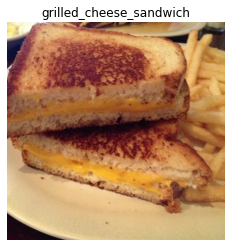

In [18]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

# **2. Creating a preprocessing function for the data**

Properties of the Food101 dataset from TFDS:
* In `uint8` dataType
* Comprised of all different size of tensors(different sized images)
* Note scaled(the pixel values are between 0 & 255)

Neural Network models work best in:
* Data in `float 32` dataType (or for mixed precision `float 16` and `float 32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (value between 0 & 1) also called normalized tensors generally perform better

The preprocessing function should tackle all above issues.

If `EfficientNetBX` pretrained model from `tf.keras.applications`. There is no need to rescale the data(these architectures have rescaling layer bulit in).

Thus, the preprocessing function needs to perform:
1. Reshape the images to all the same size
2. Convert the dtype of the image tensors from `uint8` to `float 32`


In [19]:
# Create a function for preprocessing images

def preprocess_img(image, label, img_shape=224):
  """
  Converts image dtype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, color_channels]
  """
  # Reshape the target image
  image = tf.image.resize(image, [img_shape, img_shape])

  # Return a tuple (float32_image, label)
  return tf.cast(image, tf.float32), label 

# Trial of the preprocess function
preprocessed_img = preprocess_img(image, label)[0]

print(f"Image before preprocessing:\n {image[:2]}..., \n Shape: {image.shape}, \n DataType: {image.dtype} \n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \n Shape: {preprocessed_img.shape}, \n DataType: {preprocessed_img.dtype} \n")

Image before preprocessing:
 [[[239 217 157]
  [244 222 162]
  [247 227 168]
  ...
  [119 104  73]
  [111  95  70]
  [105  89  66]]

 [[233 212 149]
  [239 218 155]
  [243 223 162]
  ...
  [117 102  71]
  [108  92  67]
  [101  85  62]]]..., 
 Shape: (512, 512, 3), 
 DataType: <dtype: 'uint8'> 

Image after preprocessing:
 [[[238.7704   217.41327  155.4847  ]
  [242.83673  222.83673  162.55101 ]
  [240.85713  220.20918  164.2143  ]
  ...
  [131.28564  118.28565   75.7806  ]
  [123.88257  109.81113   75.09689 ]
  [106.698746  90.698746  66.4131  ]]

 [[232.16325  212.09183  141.37755 ]
  [238.86224  219.86224  151.07654 ]
  [239.94388  221.08673  155.87245 ]
  ...
  [127.49998  112.49998   71.07145 ]
  [122.63767  106.56623   72.852   ]
  [105.83142   88.47424   63.1886  ]]]..., 
 Shape: (224, 224, 3), 
 DataType: <dtype: 'float32'> 



# **3. Batching & Preparing datasets for modelling (making them run fast)**

To make a **Data Input Pipeline** that run really fast, referencing https://www.tensorflow.org/guide/data for details

In [20]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to testing (and parallelize), batching, prefetching in 1 line of code
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [21]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## **Create Model Callbacks**

Create below callbacks:
* TensorBoard callback to log training results (for visualization in the futurn if necessary)
* ModelCheckpoint callback to save the model's training pregress after feature extraction

In [22]:
# Create ModelCheckpoint callback to save model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

# **4. Setting up `mixed precision training` (fast model training)**

Referencing https://www.tensorflow.org/guide/mixed_precision for a deeper understanding of mixed precision training.

Mixed precision utilizes a combination of `float32` and `float16` data types to speed up model performance.

In [23]:
# Turn on mixed precision training

# Set global data policy to mixed precision
mixed_precision.set_global_policy("mixed_float16")

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


## **Build Feature Extraction Model**

In [24]:
# Creation of the base model and freeze its layers (Feature extraction)

# 1. Initialize input shape
input_shape = (224, 224, 3)

# 2.Initialize the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 3. Freezing the base model
base_model.trainable = False

# 4. Create input layer into the model
inputs = layers.Input(shape=input_shape, name="input_layer")

# 5. Add in data augmentation layer created above
# x = data_augmentation(inputs)

# 6. Pass augmented inputs to the base model
x = base_model(inputs, training=False)

# 7. Pass the outputs features from base model to pooling layer to get a feature vector
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 8. Add the dense layer
x = layers.Dense(len(class_names))(x)

# 9. Add the output layer
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 

# 10. Create the complete model
model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])



16711680/16705208 [==============================] - 0s 0us/step


In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


## **Checking layer dtype policies(Verify whether mixed precision is using)**

In [28]:
# Check the dtype_policy attributes of layers in the feature extraction model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Above shows that:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not(if `False`, weights are frozen)
* `layer.dtype`: the data type a layer stores its variables in
* `layer.dtype_policy`: the data type policy a layer computes on its variables with

In [29]:
# Check the dtype_policy attributes of layers in the base model EfficientNetB0
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <

## **Fit the feature extraction model with mixed precision**

if fine tuning is th ultimate goal, the general workflow is:
1. Build a feature extraction model (train a couple output layers with base layers frozen for a few epochs)
2. Fine-tune some of the forzen layers of the base model layers

In [ ]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3, 
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientNetB0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])